In [36]:
import numpy as np
import sympy
from matplotlib import pyplot as plt
import scipy
import scipy.optimize
import scipy.integrate
import CoolProp.CoolProp as CP
from scipy.stats.mstats import gmean

## Assumptions:

1. Constant liquid hold up on each plate 
2. Constant liquid flow in each of the three sections of the column
3. Constant vapour flow in the column
4. No vapour holdup in the column
5. Constant hold up in reboiler and condenser
6. Constant relative volatility

## The functions below are used for the VLE data

- The first function is based on a constant relative volatility assumption calculate as an average from the data set at 1 atm. Here a geometrial mean is used due to the volatility of the data set.
- The second function is based on VLE data collected from a system at a pressure of 1 atm.

In [37]:
def rel_vol(xi):
    
    xi = np.asarray(xi)
    x= np.asarray([ 0.019, 0.0721, 0.0966, 0.1238, 0.1661, 0.2337, 0.2608, 
              0.3273, 0.3965, 0.5079, 0.5198, 0.5732, 0.6763, 0.7472, 0.8943])
    y = np.asarray([ 0.170, 0.3891, 0.4375, 0.4704, 0.5089, 0.5445, 0.5580, 
              0.5826, 0.6122, 0.6564, 0.6599, 0.6841, 0.7385, 0.7815, 0.8943])
    
    αi = (y*(1-x))/(x*(1-y))
#     α = np.average(αi)
    α = gmean(αi)
    xi = (α*xi)/(1+(α-1)*xi)
    
    return xi

rel_vol([0.27,0.3,0.556])

array([0.52922059, 0.56570296, 0.79192729])

In [38]:
def vle_data(xi):
    
    x_data = [0, 0.019, 0.0721, 0.0966, 0.1238, 0.1661, 0.2337, 0.2608, 
              0.3273, 0.3965, 0.5079, 0.5198, 0.5732, 0.6763, 0.7472, 0.8943, 1]
    y_data = [0, 0.170, 0.3891, 0.4375, 0.4704, 0.5089, 0.5445, 0.5580, 
              0.5826, 0.6122, 0.6564, 0.6599, 0.6841, 0.7385, 0.7815, 0.8943, 1]
    
    x = np.interp(xi,x_data, y_data)
    return x

vle_data([0.27,0.3,0.556])

array([0.56140331, 0.57250105, 0.67630524])

# Vectorized Equations #

$\frac{dx_i}{dt} = \left(\frac{1}{M_i}\right)\left(V(y_{i+1}-y_{i}) + L_1(x_{i-1}-x_{i}) + Fx_F \right)$

A vector is utilied for the following variables:
- $y_{i+1}$
- $y_{i}$
- $x_{i}$
- $x_{i-1}$
- $L_1$
- $F$

## Feed vector function
- This function creates 4 vectors for the flow.
- The first two vectors are the liquid flows.
- The third vector is the feed vector.
- The fourth vector contains the reflux and the boilup.

In [39]:
def feed_vector(plates,feedplate,feed):
    
    L1 = R_r*D
    V = L1 + D
    L2 = F + L1
    
    R = V - L1
    BU = L2 - V
    
    feed_vec1 = np.zeros(plates)
    feed_vec2 = np.zeros(plates)
    flow_vec_top = np.zeros(plates)
    flow_vec_bot = np.zeros(plates)
    
    flow_vec_top[0:feedplate] = L1
    flow_vec_top[feedplate:] = L2
    
    flow_vec_bot[0:feedplate-1] = L1
    flow_vec_bot[feedplate-1:] = L2
    
    feed_vec1[feedplate-1] = feed
    feed_vec2[0] = R
    feed_vec2[-1] = BU
    
    return np.asarray([flow_vec_top,flow_vec_bot,feed_vec1,feed_vec2])



In [40]:
feed_vector(12,4,1)

array([[0.3, 0.3, 0.3, 0.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3],
       [0.3, 0.3, 0.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3],
       [0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5]])

## Composition vector function
- This function calculates the 4 different composition vectors needed to complete the mass balance from the following equation:
$\frac{dx_i}{dt} = \left(\frac{1}{M_i}\right)\left(V(y_{i+1}-y_{i}) + L_1(x_{i-1}-x_{i}) + Fx_F \right)$

In [41]:
def comp_vector(xi,yi):
    
    xi = np.asarray(xi)
    yi = np.asarray(yi)
    
    xi1 = np.copy(xi)
    xi1 = np.roll(xi1, 1)
    xi1[0] = 0
    
    xi2 = np.copy(xi)
    xi2[-1] = 0
    
    yi1 = np.copy(yi)
    yi1 = np.roll(yi1, -1)
    yi1[-1] = 0
    
    yi2 = np.copy(yi)
    yi2[0] = 0
    
    
    return np.asarray([xi1,xi2]),np.asarray([yi1,yi2])

In [42]:
def holdup_vector(plates,feedplate, m_cond,m_tray,m_rebl):
    holdup_vec = np.zeros(plates)
    
    holdup_vec[0] = m_cond
    holdup_vec[-1] = m_rebl
    holdup_vec[1:plates-1] = m_tray
    
    return holdup_vec

In [43]:
holdup_vector(12,4, 0.15, 0.2,0.45)

array([0.15, 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.45])

## Heat capacity function 
- This function calculates the heat capacity of the liquid holdup on each plate
- The heat capacity is used to calculate the temperature on the plate.

In [44]:
def Cp(xi):
    CPi = []
    
    for i in range(len(xi)):
        CPi.append(CP.PropsSI('CPMOLAR','Q',0,'P',101325,f'Ethanol[{xi[i]}]&Water[{1-xi[i]}]'))
    return np.asarray(CPi)

In [45]:
Cp([0.5,0.6,0.7])

array([117.45980637, 122.1498239 , 126.25094095])

## Ethalpy function 
- Vectors corrosponding to the flow vectors are calculated and shaped correctly.
- This function calculates liquid and vapour enthalpy.
- The pressure is currently assumed to be costant and set equal to 101.325 kPa.

In [63]:
def H(xi,yi,Ti):
    Hi_L = []
    Hi_V = []
    
    for i in range(len(xi)):
        Hi_L.append(CP.PropsSI('HMOLAR','Q',0,'P',101325,f'Ethanol[{xi[i]}]&Water[{1-xi[i]}]'))
        Hi_V.append(CP.PropsSI('HMOLAR','Q',1,'P',101325,f'Ethanol[{yi[i]}]&Water[{1-yi[i]}]'))
        
    Hi_L = np.asarray(Hi_L)
    Hi_V = np.asarray(Hi_V)
    
    Hi_L1 = np.copy(Hi_L)
    Hi_L1 = np.roll(Hi_L1, 1)
    Hi_L1[0] = 0
    
    Hi_L2 = np.copy(Hi_L)
    Hi_L2[-1] = 0
    
    Hi_V1 = np.copy(Hi_V)
    Hi_V1 = np.roll(Hi_V1, -1)
    Hi_V1[-1] = 0
    
    Hi_V2 = np.copy(Hi_V)
    Hi_V2[0] = 0
    
    return [Hi_L,Hi_L1,Hi_L2,Hi_V,Hi_V1,Hi_V2]

In [64]:
H([0.6,0.7,0.8],[0.432419,0.6,0.7],[200,200,200])

[array([2745.1411304 , 2077.85447   , 1399.61294788]),
 array([   0.       , 2745.1411304, 2077.85447  ]),
 array([2745.1411304, 2077.85447  ,    0.       ]),
 array([44321.97603927, 42642.71156039, 41702.05289461]),
 array([42642.71156039, 41702.05289461,     0.        ]),
 array([    0.        , 42642.71156039, 41702.05289461])]

## Reboiler and Condenser Duty

In [65]:
def duty(plates,feedplate,Qcond,Qrebl):
    duty_vector = np.zeros(plates)
    duty_vector[0] = Qcond

    duty_vector[-1] = Qrebl
    
    return duty_vector

duty(12,4,-2394,798)

array([-2394.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,   798.])

## Vectozied model of the column

In [66]:
def mass_DE(t,var):
    
    # values for compositon and temperature is fed as a 1-D array and reshaped
    x,T = np.reshape(var,(2,-1))
    
    xi = np.asarray(x)
    Ti = np.asarray(T)
    
    L1 = R_r*D
    V = L1 + D
    L2 = F + L1
    
    R = V - L1
    BU = L2 - V
    
    yi = vle_data(xi) # change to vle_data() for interpolation of vapour liquid equilibrium
    
    
    if t<15:
        feedplate = 4
    else:
        feedplate = 4 # change this to vary which plate is fed on
    
    flow1, flow2, feed1, feed2 = feed_vector(plates,feedplate, F)
    
    x1, y1 = comp_vector(xi,yi)
    holdup_vec = holdup_vector(plates,feedplate, m_cond,m_tray,m_rebl)

    
    # component mass balance 
    
    dxdt = 1/holdup_vec * (V*(y1[0] - y1[1]) + flow1*x1[0] - flow2*x1[1] + feed1*xF  - feed2*xi)
    
    
    
    
    HL,HL1, HL2, HV, HV1, HV2 = H(xi,yi,Ti)
    CPi = Cp(xi)
    duty_vector = duty(plates,feedplate,-2.23715592e+03,7.45718639e+02)

    # Energy balance
    
    dTdt = 1/(holdup_vec*CPi)*( V*(HV1 - HV2) + flow1*HL1 - flow2*HL2 + feed1*HL - feed2*HL) + duty_vector

    dTdt = np.zeros(len(Ti))  # Unhash this to just use mass balance

    didt = np.concatenate([dxdt, dTdt])

    return didt

In [67]:
# plates is the number of total plates + 2 (for the reboiler and condenser)
# feedplate is the plate number the feed occurs on
# x_initial is an array with the initial column states

plates = 12
feedplate = 4

## Inputs to calculate intial state

### Input variables

1. $F_3$ - Feed flow rate on plate 3
2. $F_7$ - Feed flow rate on plate 7
3. $x_F$ - Feed liquid composition
4. $Rr$ - Reflux ratio
5. $D_F$ - Distillate to feed ratio

### Parameters

1. $\alpha$ - Relative volatility
2. $m_{tray}$ - holdup on each tray
2. $m_{cond}$ - holdup in the total condenser
2. $m_{rebl}$ - holdup in the partial reboiler

In [68]:
init_comp = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
init_temp = np.array([303,303,303,303,303,303,303,303,303,303,303,303])

init = np.concatenate([init_comp,init_temp])

x,T = np.reshape(init,(2,-1))
print(x)
print(T)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[303. 303. 303. 303. 303. 303. 303. 303. 303. 303. 303. 303.]


In [69]:
init_comp = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
init_temp = np.array([303,303,303,303,303,303,303,303,303,303,303,303])

init = np.concatenate([init_comp,init_temp])

F = 1 # Feed on plate 3
D =0.5
xF = 0.5 # mole fraction in feed
R_r = 0.6 # reflux ratio
m_cond = 0.15 # holdup in condenser
m_tray = 0.2 # holdup on each tray
m_rebl = 0.45 # holdup in reboiler
α = 1.6 # relative volatility



In [70]:
mass_DE(0,init)

array([ 1.82193333,  0.        ,  0.        ,  2.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.60731111,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [71]:
tspan = (0,15)
t = np.linspace( *tspan, 100)
initial_run = scipy.integrate.solve_ivp(mass_DE, tspan, init, t_eval=t)

ValueError: solver_rho_Tp was unable to find a solution for T=       nan, p=    101325, with guess value    15021.3 with error: p is not a valid number : PropsSI("HMOLAR","Q",1,"P",101325,"Ethanol[0.42875788852149627]&Water[0.5712421114785038]")

In [32]:
x = initial_run.y

0.49999996298536203 6.321711940253883e-08


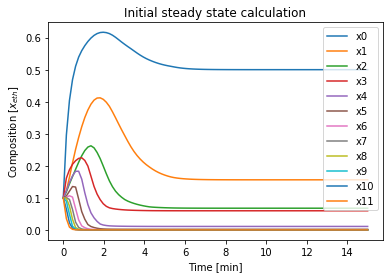

In [33]:
plt.figure(1)
plt.title("Initial steady state calculation")

for i in range(0,12) :
    plt.plot(t,initial_run.y[i], label="x{}".format(i))
    
plt.xlabel("Time [min]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")
plt.savefig("Basic_distillation_column_V3.svg")
print(initial_run.y[0,-1],initial_run.y[11,-1])

# Consistency plot of model

The idea to assume CMO and constant hold up creates a scenario where mass is "created" to fulfill both the criterias. The plot below will show that there accumulation occuring in the column increases yet the mass balance decreases to zero. These two are thus contradictory because the mass balance should produce the exact same accumulation.

The mass balance is calculated as follows:

$M_{t}\frac{dx_t}{dt} = x_FF -x_BB - x_DD $

And the accumulation is calculated as follows:

$M_{t}\frac{dx_t}{dt} = \sum{M_i\frac{dx_i}{dt}}$

where 
- $M_t$ is the total mass accumulated in the column
- $x_t$ is the mole fraction of the mass in the column
- $M_i$ is the total mass accumulated on each tray $i$.

In [ ]:
L1 = R_r*D
V = L1 + D
L2 = F + L1


holdup_vec = holdup_vector(plates,feedplate, m_cond,m_tray,m_rebl)

moles_inside_column_at_zero = x[0:12,0]*holdup_vec

moles_inside_column = (x[0,:]*m_cond + x[1,:]*m_tray + x[2,:]*m_tray + x[3,:]*m_tray + x[4,:]*m_tray + x[5,:]*m_tray
                      + x[6,:]*m_tray+ x[7,:]*m_tray+ x[8,:]*m_tray+ x[9,:]*m_tray+ x[10,:]*m_tray+ x[11,:]*m_rebl -
                      np.sum(moles_inside_column_at_zero)) 


# moles_inside_column_at_zero = (x0s[0]*m_cond+x1s[0]*m_tray+x2s[0]*m_tray+x3s[0]*m_tray+x4s[0]*m_tray+x5s[0]*m_tray+x6s[0]*m_tray+
#                        x7s[0]*m_tray+x8s[0]*m_tray+x9s[0]*m_tray+x10s[0]*m_tray+x11s[0]*m_rebl)

# This calculated the accumulation insie the column through summing the accumulation on each plate
# moles_inside_column = (x0s*m_cond+x1s*m_tray+x2s*m_tray+x3s*m_tray+x4s*m_tray+x5s*m_tray+x6s*m_tray+
#                        x7s*m_tray+x8s*m_tray+x9s*m_tray+x10s*m_tray+x11s*m_rebl) - moles_inside_column_at_zero



# integral = []
# for i in range(1,len(t)+1):
#     dMtxtdt = xF*F3 - (D)*(x0s[0:i])- (L3-V)*x11s[0:i]
#     integral.append(np.trapz(dMtxtdt,t[0:i]))



# plt.figure(1)
# plt.title("Consistency Plot")
# plt.xlabel("Time")
# plt.ylabel("Accumulation of mass")
# plt.plot(t,integral, label = "Mole balance")
# plt.plot(t,moles_inside_column, label = "Diff equations")
# plt.legend(loc="best")
# plt.savefig("consistency_plot.png")
# plt.figure(2)
# plt.plot(t,abs(moles_inside_column-integral), label = "Error")
# plt.xlabel("Time")
# plt.ylabel("Error")
# plt.savefig("consistency_plot_error.png")

In [ ]:
# Now lets ee if we can use the vector version for a different setup...

plates = 20
feedplate = 9

init = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

tspan = (0, 50)
t = np.linspace( *tspan, 100)
initial_run = scipy.integrate.solve_ivp(mass_DE, tspan, init, t_eval=t)

x = initial_run.y

for i in x:
    plt.plot(t,i)
